# Figure 3: conditional CGF applications to MNIST

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import seaborn as sns
import plotly.express as px

import numpy as np
import pandas as pd

import statsmodels.formula.api as smf
import torch

In [2]:
from change_detection import RateFunctionTest, ScoreTest

from cgf_network import CGF_ICNN, ConditionalCGF
from models.simple_examples import Basic_MNIST
from models.data_utilities import exact_data_ratios


from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose, Normalize
from functools import partial

# model checkpoints
classifier_ckpt = './learnedExpFam/4ttqob80/checkpoints/epoch=48-step=82712.ckpt'
CGF_ckpt = 'trainedParameters/MNIST_initial/step1_MNIST/validation-epoch=310-step=2308242.ckpt'
conditional_ckpt = 'trainedParameters/MNIST_initial/step2_MNIST/validation-epoch=128-step=8062500.ckpt'



# load MNIST data 
mnist_model = Basic_MNIST.load_from_checkpoint(classifier_ckpt)
mnist_model.setup()
mnist_model.fit_activity_transform(mnist_model.data_train)

activity_dataset_train = mnist_model.internal_activity_dataset(mnist_model.data_train)


mnist_test_data = MNIST('~/Datasets/', download=True, train=False,
                        transform=Compose(
                          [ToTensor(), Normalize(0., 1.),
                           partial(torch.reshape, shape=(-1,))
                           ])
                       )
activity_dataset_test = mnist_model.internal_activity_dataset(mnist_test_data)


mnist_cgf = CGF_ICNN.load_from_checkpoint(CGF_ckpt, data_to_model=activity_dataset_train[:][0])
conditional_mnist = ConditionalCGF.load_from_checkpoint(conditional_ckpt,
                                                        dataset_to_model=activity_dataset_train,
                                                       numsamples=1000)
conditional_mnist.setup()

setup called


## General figure formatting

In [20]:
figsize(1.5,0.5)
plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':True, 'top':True})
plt.rc('font', size=10)
plt.rc('lines', linewidth=1.8)
plt.rcParams['text.usetex'] = True

In [4]:
from sklearn.linear_model import LinearRegression

def sample_means(dataset, N_mean, num_samples, target_weights={i:1. for i in range(10)}):
    """ Sample the average of N_mean activity values
        target_weights are the relative probabilities of different targets
    """
    possible_inds =  len(dataset)

    _, all_targets = dataset[:]
    probs = np.fromiter(map(lambda x: target_weights[x.item()], all_targets), dtype=float)
    probs = probs / sum(probs)
    
    indices = np.random.choice(possible_inds, (num_samples, N_mean), p=probs)
    activity, targets = dataset[indices]
    

    return activity.mean(1), targets

def prior_regression( N_mean, distribution):
    means, t = sample_means(activity_dataset_test, N_mean, 200, distribution)

    parameters = conditional_mnist.make_parameters(torch.arange(10))
    conditional_means = conditional_mnist.jac(parameters).detach()

    priors = torch.zeros(200, 10)
    
    for i in range(200):
        l = LinearRegression(fit_intercept=False, positive=True)
        l.fit(conditional_means.T, means[i])
        priors[i] = torch.as_tensor(l.coef_ / sum(l.coef_))

    return priors.mean(0), priors.var(0)**0.5

In [5]:
distributions = []

alt_weights={i:1. for i in range(10)}
alt_weights[2] = 0
alt_weights[4] = 0
distributions.append(alt_weights)

alt_weights={i:1. for i in range(10)}
alt_weights[2] = 2
distributions.append(alt_weights)

alt_weights={i:1. for i in range(10)}
alt_weights[2] = 2
alt_weights[9] = 2
alt_weights[8] = 2
distributions.append(alt_weights)

alt_weights={i:1. for i in range(10)}
alt_weights[0] = 1.5
alt_weights[1] = 1.5
alt_weights[2] = 1.5
alt_weights[3] = 1.5
alt_weights[4] = 1.5

distributions.append(alt_weights)

baseline={i:1. for i in range(10)}

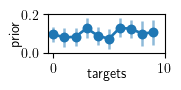

In [46]:
meansbase, stdsbase = prior_regression(100, baseline)
plt.errorbar(range(10), meansbase, fmt='-o', yerr=stdsbase, alpha=0.5)
plt.plot(range(10), meansbase, '-oC0')
plt.xticks([0, 10])
plt.xlabel('targets', labelpad=-5)
plt.ylabel('prior', labelpad=-1)
plt.ylim([0, 0.2])
plt.savefig('distbaseline.png', dpi=1000, bbox_inches='tight', pad_inches=0.02)

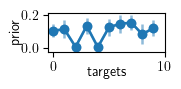

In [47]:
means0, stds0 = prior_regression(100, distributions[0])
plt.errorbar(range(10), means0, fmt='-o', yerr=stds0, alpha=0.5)
plt.plot(range(10), means0, '-oC0')
plt.xticks([0, 10])
plt.xlabel('targets', labelpad=-5)
plt.ylabel('prior', labelpad=-1)
plt.savefig('dist0.png', dpi=1000, bbox_inches='tight', pad_inches=0.02)

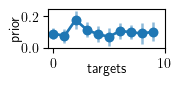

In [48]:
means1, stds1 = prior_regression(100, distributions[1])
plt.errorbar(range(10), means1, fmt='-o', yerr=stds1, alpha=0.5)
plt.plot(range(10), means1, '-oC0')
plt.xticks([0, 10])
plt.xlabel('targets', labelpad=-5)
plt.ylabel('prior', labelpad=-1)
plt.yticks([0, 0.2])
plt.savefig('dist1.png', dpi=1000, bbox_inches='tight', pad_inches=0.02)

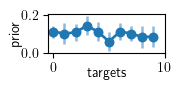

In [50]:
means2, stds2 = prior_regression(100, distributions[3])
plt.errorbar(range(10), means2, fmt='-o', yerr=stds2, alpha=0.5)
plt.plot(range(10), means2, '-oC0')
plt.xticks([0, 10])
plt.xlabel('targets', labelpad=-5)
plt.ylabel('prior', labelpad=-1)
plt.yticks([0, 0.2])
plt.savefig('dist2.png', dpi=1000, bbox_inches='tight', pad_inches=0.02)

In [137]:
def log_conditional_distribution(x, conditional_model=conditional_mnist):
    """ log-likelihood under the tilted prior """
    n_samples = x.shape[0]
    parameters = conditional_model.make_parameters(torch.arange(10))

    input_projection = x @ parameters.T
    normalizers = conditional_model.forward(parameters.to(conditional_model.device)).cpu()
    normalizers = normalizers.T.repeat(n_samples,1)
    
    return input_projection - normalizers


def bayesian_posterior(x, prior, conditional_model=conditional_mnist):
    """ perform bayes inference on the points in question """
    n_samples = x.shape[0]

    log_prior = torch.log(prior).repeat(n_samples, 1)
    log_posterior = log_conditional_distribution(x, conditional_model) + log_prior

    softmax = torch.nn.Softmax(dim=1)

    return softmax(log_posterior)
    

In [138]:
inputs = conditional_mnist.data
targets = conditional_mnist.targets
torch.argmax(log_conditional_distribution(inputs), dim=1)

tensor([9, 1, 1,  ..., 1, 5, 1])

In [139]:
data = {}

In [140]:
prior = torch.ones(10) / 10.
posterior = torch.argmax(bayesian_posterior(inputs, prior), dim=1)
data['uniform'] = (posterior == targets).sum() / posterior.shape[0] 

In [141]:
data['uniform']

tensor(0.8370)

In [144]:
def sample_activity(dataset, N_mean, num_samples, target_weights={i:1. for i in range(10)}):
    """ Sample the average of N_mean activity values
        target_weights are the relative probabilities of different targets
    """
    possible_inds =  len(dataset)

    _, all_targets = dataset[:]
    probs = np.fromiter(map(lambda x: target_weights[x.item()], all_targets), dtype=float)
    probs = probs / sum(probs)
    
    indices = np.random.choice(possible_inds, (num_samples, N_mean), p=probs)
    activity, targets = dataset[indices]
    

    return activity, targets

def evaluate_performance(N, distribution):
    inputs, targets = sample_activity(activity_dataset_test, 1, 5000, target_weights=distribution)
    inputs = inputs.squeeze()
    targets = targets.squeeze()

    prior = torch.zeros(10)
    for i in range(10):
        prior[i] = distribution[i]
    prior = prior / prior.sum()

    decoded = torch.argmax(bayesian_posterior(inputs, prior), dim=1)
    return (decoded == targets).sum() / decoded.shape[0]
    
    

In [146]:
data['dist0'] = evaluate_performance(5000, distributions[0])

In [147]:
data['dist1'] = evaluate_performance(5000, distributions[1])

In [148]:
data['dist2'] = evaluate_performance(5000, distributions[3])

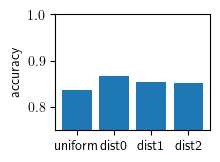

In [159]:
figsize(2,1.5)
plt.bar(data.keys(), data.values())
plt.ylim([0.75, 1.])
plt.ylabel('accuracy')
plt.savefig('figure3b.png', dpi=1000, bbox_inches='tight', pad_inches=0.02)